In [10]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

In [5]:
import h5py
import os
file_path = 'uniform_bz.h5'
print(f"Working dir: {os.getcwd()}")
print(f"File exists: {os.path.exists(file_path)}")
if os.path.exists(file_path):
    with h5py.File(file_path, 'r') as f:
        print('Keys:', list(f.keys()))


Working dir: /home/debian/build/tests/boris
File exists: True
Keys: ['vx', 'vy', 'vz', 'x']


            Larmor radius  Cyclotron frequency
Theory           0.666667              3.00000
Simulation       0.666667              2.99985


/jup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


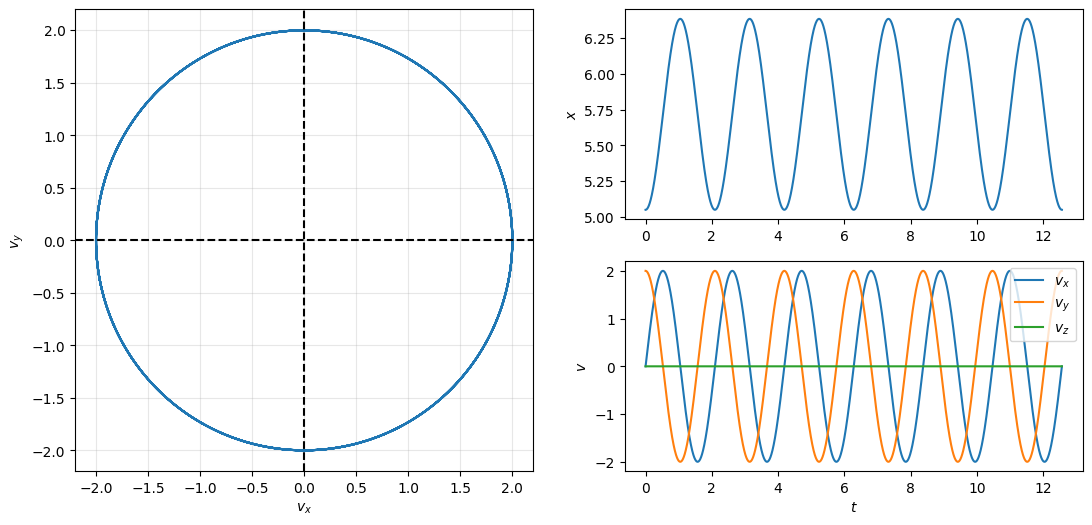

In [12]:
# Load data
with h5py.File('uniform_bz.h5', 'r') as f:
    pos_x = f['x'][:]
    vx, vy, vz = f['vx'][:], f['vy'][:], f['vz'][:]
    n_steps = len(pos_x)

# Parameters
center_x = np.mean(pos_x)
v_mag = 2.0
B_strength = 3.0
q, m = 1.0, 1.0
dt = 1e-3

time = np.arange(n_steps) * dt

# Theory
omega_theory = q * B_strength / m
r_theory = v_mag / omega_theory

# Simulation
r_sim = (np.max(pos_x) - np.min(pos_x)) / 2

# FFT peak frequency
signal = pos_x - center_x
fft_vals = np.abs(rfft(signal))
freqs = rfftfreq(n_steps, dt)
omega_sim = 2 * np.pi * freqs[np.argmax(fft_vals)]

# Table
table_data = {
    "Larmor radius": [r_theory, r_sim],
    "Cyclotron frequency": [omega_theory, omega_sim]
}
df = pd.DataFrame(table_data, index=["Theory", "Simulation"])
print(df)

# 3-plot layout (same as original)
fig = plt.figure(figsize=(13, 6), constrained_layout=True)
gs = plt.GridSpec(2, 2)

# Phase space (left column, full height)
ax0 = plt.subplot(gs[0:2, 0])
ax0.plot(vx, vy)
ax0.axhline(0, color='k', ls='--')
ax0.axvline(0, color='k', ls='--')
ax0.set_xlabel(r'$v_x$')
ax0.set_ylabel(r'$v_y$')
ax0.grid(True, alpha=0.3)

# x(t) top-right
ax1 = plt.subplot(gs[0, 1])
ax1.plot(time, pos_x)
ax1.set_ylabel(r'$x$')

# Velocities bottom-right  
ax2 = plt.subplot(gs[1, 1])
ax2.plot(time, vx, label=r'$v_x$')
ax2.plot(time, vy, label=r'$v_y$')
ax2.plot(time, vz, label=r'$v_z$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$v$')
ax2.legend()

plt.show()

E×B Drift Analysis:
            Larmor radius  Cyclotron freq (rad/s)  ExB drift velocity
Theory             0.1250                  8.0000              0.1250
Simulation         0.1268                  7.9996              0.1251


/tmp/ipykernel_1762768/2055430783.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_ph.legend()
/jup/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


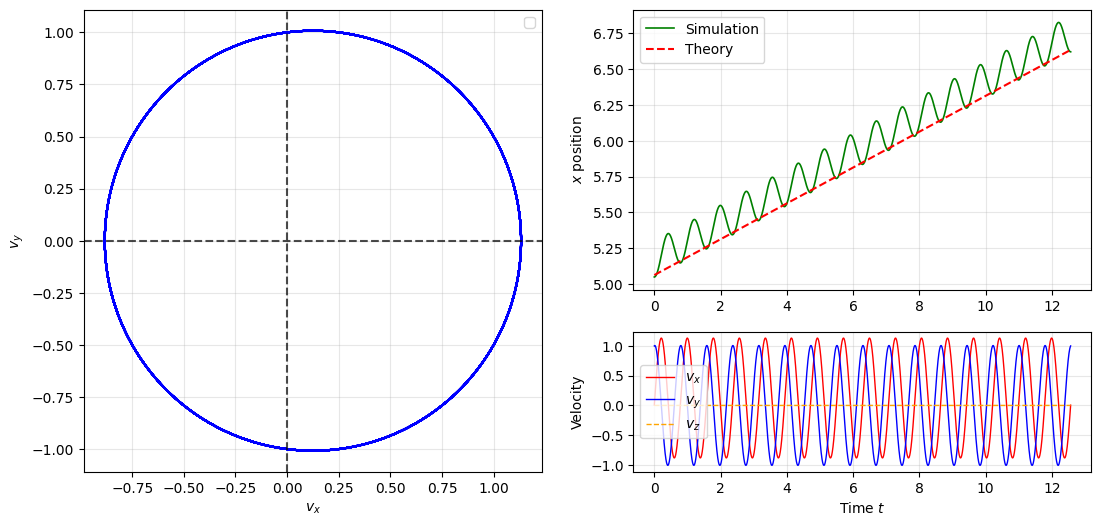

In [14]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

# Load E×B drift simulation
with h5py.File('drift_ey.h5', 'r') as f:
    pos_x = f['x'][:]
    vel = np.array([f['vx'][:], f['vy'][:], f['vz'][:]]).T
    n_steps = len(pos_x)

# Parameters for E×B drift
center_x = np.mean(pos_x[:100])  # Initial center (before drift)
v_perp = 1.0
B_mag = 8.0
E_y = 1.0
q, m = 1.0, 1.0
dt = 1e-3

time = np.arange(n_steps) * dt

# Theoretical calculations
omega_c = q * B_mag / m
r_larmor = v_perp / omega_c
v_drift = E_y / B_mag  # ExB drift velocity

# Simulation analysis
# Linear fit for drift velocity
drift_slope, drift_offset = np.polyfit(time, pos_x, 1)[:2]
r_sim = (np.max(pos_x - drift_slope * time) - np.min(pos_x - drift_slope * time)) / 2

# Cyclotron frequency from detrended oscillation
detrended = pos_x - drift_slope * time - np.mean(pos_x - drift_slope * time)
fft_signal = np.abs(rfft(detrended))
freqs = rfftfreq(n_steps, dt)
omega_sim = 2 * np.pi * freqs[np.argmax(fft_signal)]

# Results comparison
comparison = pd.DataFrame({
    'Larmor radius': [r_larmor, r_sim],
    'Cyclotron freq (rad/s)': [omega_c, omega_sim],
    'ExB drift velocity': [v_drift, drift_slope]
}, index=['Theory', 'Simulation'])

print("E×B Drift Analysis:")
print(comparison.round(4))

# 3-plot layout (phase space + trajectories)
fig = plt.figure(figsize=(13, 6), constrained_layout=True)
gs = plt.GridSpec(2, 2, height_ratios=[2, 1])

# Phase space with drift direction
ax_ph = plt.subplot(gs[0:2, 0])
ax_ph.plot(vel[:, 0], vel[:, 1], 'b-', linewidth=1.5)
ax_ph.axhline(0, color='k', ls='--', alpha=0.7)
ax_ph.axvline(0, color='k', ls='--', alpha=0.7)
ax_ph.set_xlabel('$v_x$')
ax_ph.set_ylabel('$v_y$')
ax_ph.legend()
ax_ph.grid(True, alpha=0.3)

# Position vs time
ax_pos = plt.subplot(gs[0, 1])
ax_pos.plot(time, pos_x, 'g-', linewidth=1.2, label='Simulation')
ax_pos.plot(time, v_drift * time + center_x, 'r--', label='Theory', linewidth=1.5)
ax_pos.set_ylabel('$x$ position')
ax_pos.legend()
ax_pos.grid(True, alpha=0.3)

# Velocity components
ax_vel = plt.subplot(gs[1, 1])
ax_vel.plot(time, vel[:, 0], 'r-', label='$v_x$', linewidth=1)
ax_vel.plot(time, vel[:, 1], 'b-', label='$v_y$', linewidth=1)
ax_vel.plot(time, vel[:, 2], 'orange', ls='--', label='$v_z$', linewidth=1)
ax_vel.set_xlabel('Time $t$')
ax_vel.set_ylabel('Velocity')
ax_vel.legend()
ax_vel.grid(True, alpha=0.3)

plt.show()
